## UKBB+HCP GLM

### Imports

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from imports import *

In [50]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [51]:
# overall imports
import importlib
import data

# sim imports
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [52]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 5.0%
RAM Usage: 7.9%
Available RAM: 346.9G
Total RAM: 376.8G
52.4G


In [53]:
GPUtil.getAvailable()

[]

## Load in structural connectomes

In [54]:
HCP_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/'
print(HCP_path)

# Load stuctural connectome from ENIGMA
HCP_enigma_structural_count = load_connectome(measure='SC')
HCP_enigma_structural_count_cortical = HCP_enigma_structural_count[:100, :100]

# Load 156-region structural connectivity matrices
HCP1200_S156_structural_count = np.log1p(loadmat(HCP_path + '/4S156/4S156_DTI_count.mat')['connectivity'])
HCP1200_S156_structural_count_cortical = HCP1200_S156_structural_count[:100, :100]
HCP1200_S156_structural_QA = loadmat(HCP_path + '/4S156/4S156_DTI_QA.mat')['connectivity']
HCP1200_S156_structural_QA_cortical = HCP1200_S156_structural_QA[:100, :100]

# Load 456-region structural connectivity matrices  
HCP1200_S456_structural_count = np.log1p(loadmat(HCP_path + '/4S456/4S456_DTI_count.mat')['connectivity'])
HCP1200_S456_structural_QA = loadmat(HCP_path + '/4S456/4S456_DTI_QA.mat')['connectivity']

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


## Load in functional connectomes

In [55]:
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
UKBB_demographics.head()

UKBB_S156_functional_conn = pd.read_csv('./data/UKBB/UKBB_S156_functional_conn.csv')
UKBB_S156_functional_conn_cortical = np.array(UKBB_S156_functional_conn)[:100, :100]
UKBB_S156_labels = pd.read_csv('./data/UKBB/schaefer156_atlas_info.txt', sep='\t')['label_7network'].tolist()

UKBB_S456_functional_conn = pd.read_csv('./data/UKBB/UKBB_S456_functional_conn.csv')
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[:400, :400]
UKBB_S456_labels = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()

HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_enigma_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()


/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/

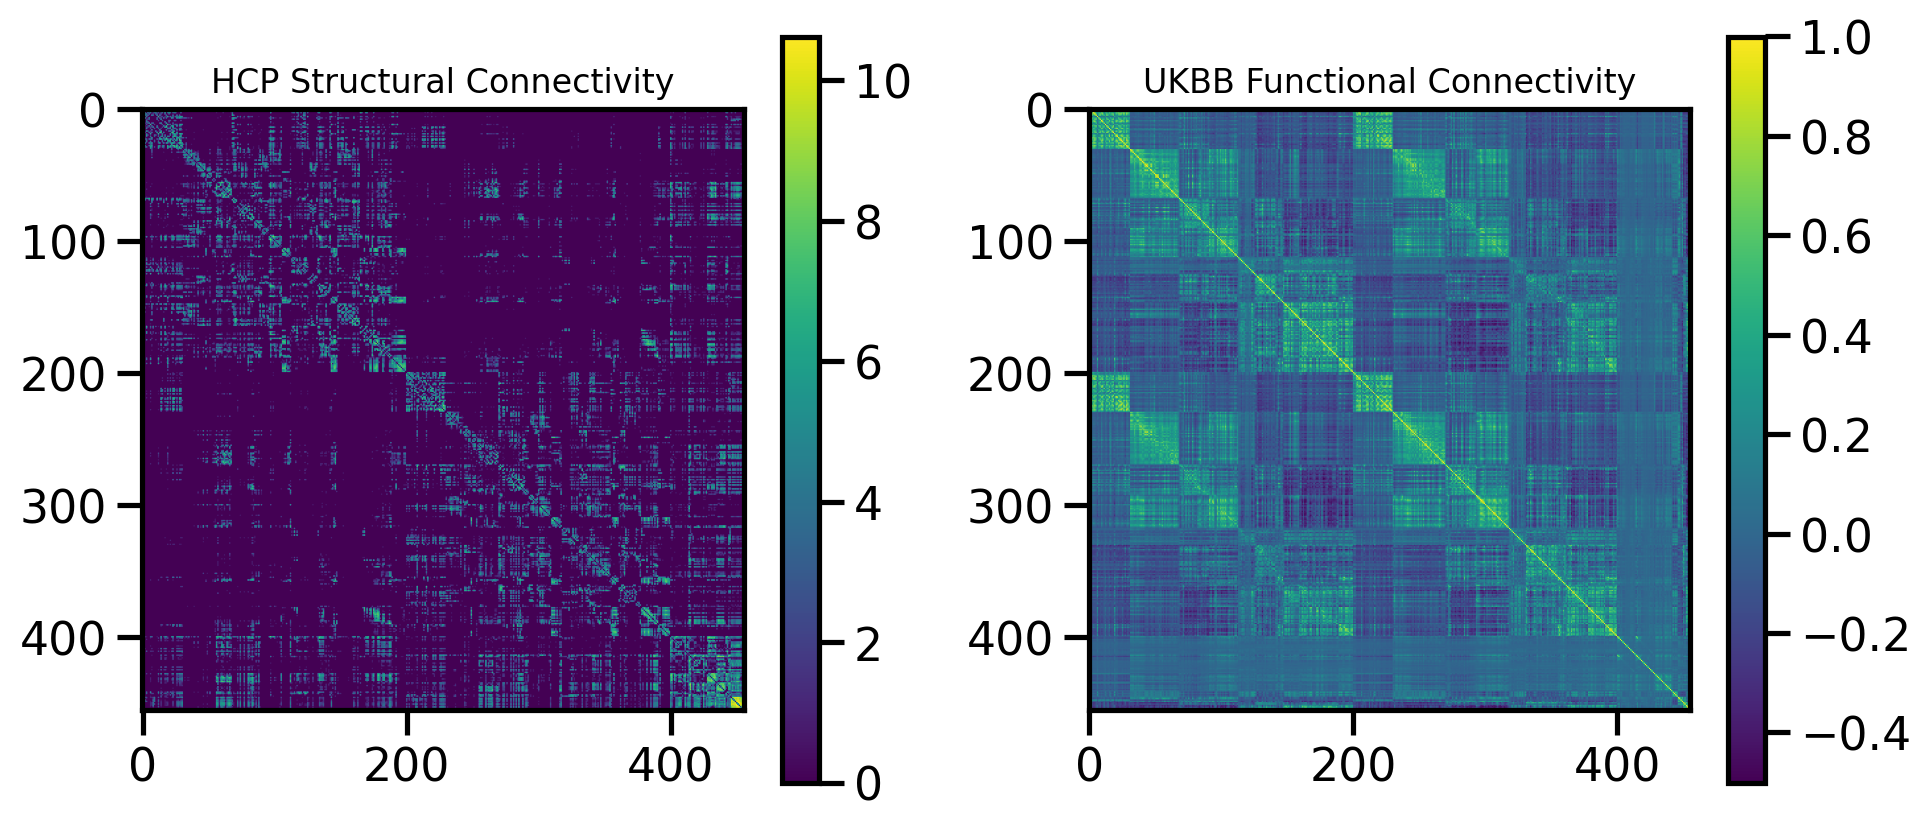

HCP Structure - UKBB Function Correlation: 0.180


In [56]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8), dpi=200)
plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('UKBB Functional Connectivity', fontsize=12)
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S456_structural_count).flatten(),
                              np.array(UKBB_S456_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


### S456 transcriptome and connectomes

In [57]:
# HCP1200 + UKBB (456)
AHBA_UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/AHBA_population_MH/'
AHBA_S456_transcriptome = pd.read_csv(os.path.join(AHBA_UKBB_path, 'AHBA_schaefer456_mean.csv'))

#UKBB_S456_atlas_info = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')
UKBB_S456_atlas_info_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/atlas_info/atlas-4S456Parcels_dseg_reformatted.csv'
UKBB_S456_atlas_info = pd.read_csv(UKBB_S456_atlas_info_path)

# Fill NaN network labels based on region labels
UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['label'].str.contains('Cerebellar', na=False)) & 
                         (UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Cerebellum'

UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Subcortex'
print(UKBB_S456_atlas_info)



                   label network_label      label_7network  index_17network  \
0               LH_Vis_1           Vis  7Networks_LH_Vis_1             61.0   
1               LH_Vis_2           Vis  7Networks_LH_Vis_2            193.0   
2               LH_Vis_3           Vis  7Networks_LH_Vis_3              1.0   
3               LH_Vis_4           Vis  7Networks_LH_Vis_4             13.0   
4               LH_Vis_5           Vis  7Networks_LH_Vis_5              2.0   
..                   ...           ...                 ...              ...   
451   Cerebellar_Region6    Cerebellum                 NaN              NaN   
452   Cerebellar_Region7    Cerebellum                 NaN              NaN   
453   Cerebellar_Region8    Cerebellum                 NaN              NaN   
454   Cerebellar_Region9    Cerebellum                 NaN              NaN   
455  Cerebellar_Region10    Cerebellum                 NaN              NaN   

                       label_17network network_labe

In [58]:
# Drop rows where all values are NaN
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

nan_rows = AHBA_S456_transcriptome.isna().any(axis=1)
AHBA_S456_transcriptome = AHBA_S456_transcriptome[~nan_rows]
UKBB_S456_atlas_info = UKBB_S456_atlas_info[~nan_rows]

# Check if any NaN values remain
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

AHBA_S456_transcriptome = AHBA_S456_transcriptome.drop('label', axis=1)
# Get list of genes from schaefer 100 data
genes_data = pd.read_csv(f"./data/enigma/allgenes_stable_r0.2_schaefer_100.csv")
genes_list = genes_data.columns.tolist()
genes_list.remove('label')

# Subset AHBA_S456 to only include these genes 
AHBA_S456_transcriptome = AHBA_S456_transcriptome[genes_list]


Number of rows with any NaN values: 66
Number of rows with any NaN values: 0


AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (456, 456)
UKBB_S456_functional_conn shape: (456, 456)


Text(0.5, 1.0, 'HCP1200 Structural Connectivity (nan rows removed)')

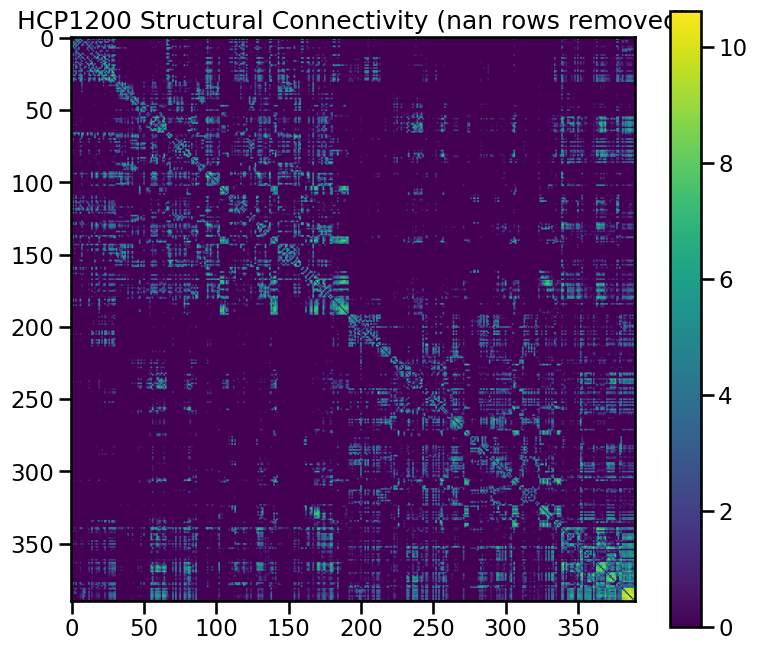

In [59]:
print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

# Store labels and network labels from atlas info
region_labels = UKBB_S456_atlas_info['label'].tolist()
network_labels = UKBB_S456_atlas_info['network_label'].tolist()
# Store MNI coordinates from atlas info as list of [x,y,z] coordinates
mni_coords = [[x, y, z] for x, y, z in zip(UKBB_S456_atlas_info['mni_x'], 
                                          UKBB_S456_atlas_info['mni_y'],
                                          UKBB_S456_atlas_info['mni_z'])]

# Remove nan rows and columns from connectomes using nan_rows directly
HCP1200_S456_structural_count = HCP1200_S456_structural_count[~nan_rows][:, ~nan_rows]

# Display resulting connectomes
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar()
plt.title('HCP1200 Structural Connectivity (nan rows removed)')


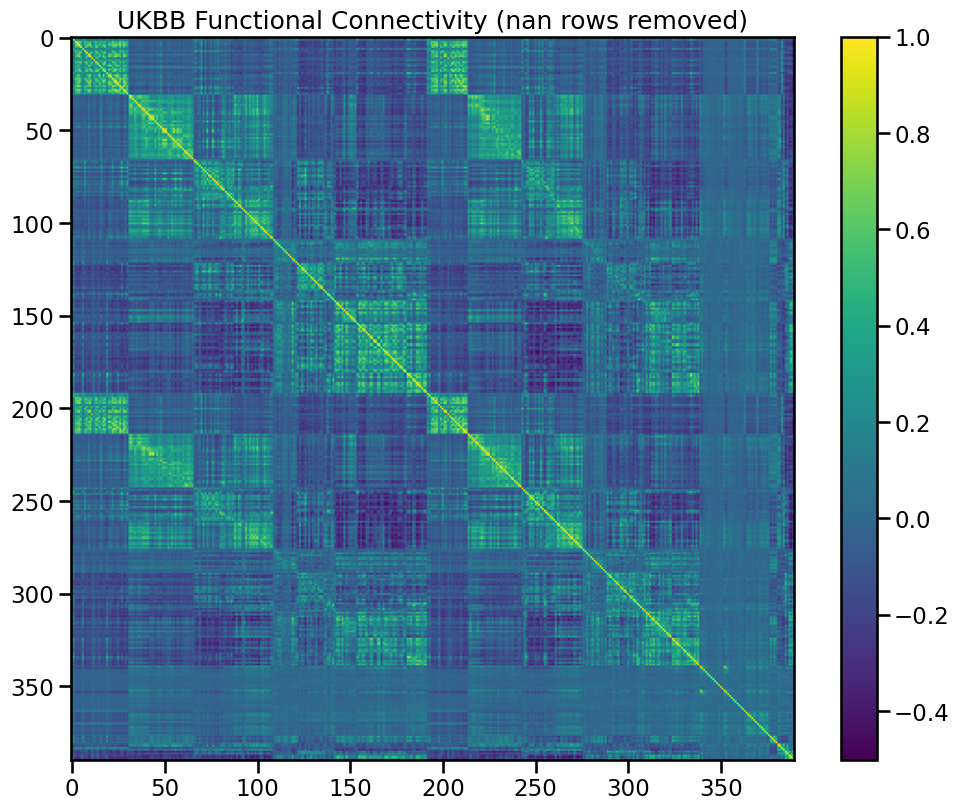

In [60]:

plt.figure(figsize=(20, 8))

UKBB_S456_functional_conn = np.array(UKBB_S456_functional_conn)[~nan_rows][:, ~nan_rows]
plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar()
plt.title('UKBB Functional Connectivity (nan rows removed)')

plt.tight_layout()
plt.show()

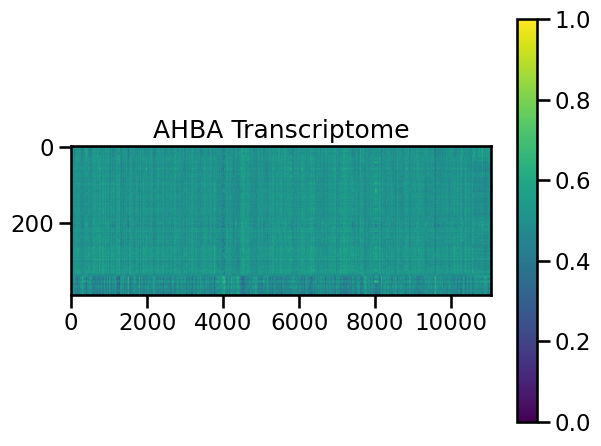

In [61]:
plt.imshow(AHBA_S456_transcriptome, cmap='viridis', aspect=10)
plt.title('AHBA Transcriptome')
plt.colorbar()
plt.tight_layout()
plt.show()


In [62]:
print("Network labels shape:", len(network_labels))
print("Region labels shape:", len(region_labels))
print("MNI coordinates shape:", len(mni_coords))

print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

Network labels shape: 390
Region labels shape: 390
MNI coordinates shape: 390
AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (390, 390)
UKBB_S456_functional_conn shape: (390, 390)


In [63]:
# Filter out subcortex and cerebellum networks
cortical_mask = ~np.array([label in ['Subcortex', 'Cerebellum'] for label in network_labels])
AHBA_cortical_transcriptome = np.array(AHBA_S456_transcriptome)[cortical_mask]
cortical_network_labels = np.array(network_labels)[cortical_mask]
cortical_region_labels = np.array(region_labels)[cortical_mask]
cortical_mni_coords = np.array(mni_coords)[cortical_mask]

# Filter structural and functional connectivity matrices using cortical mask
HCP1200_S456_structural_count_cortical = np.array(HCP1200_S456_structural_count)[cortical_mask][:, cortical_mask]
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[cortical_mask][:, cortical_mask]

print("Cortical transcriptome shape:", AHBA_cortical_transcriptome.shape)
print("Cortical structural connectivity shape:", HCP1200_S456_structural_count_cortical.shape)
print("Cortical functional connectivity shape:", UKBB_S456_functional_conn_cortical.shape)

Cortical transcriptome shape: (339, 11053)
Cortical structural connectivity shape: (339, 339)
Cortical functional connectivity shape: (339, 339)


#### Create subdatasets for left hemisphere, right hemisphere, and interconnections

Left hemisphere

In [64]:
# Isolate nodes from the left hemisphere only
# Create mask for left hemisphere regions
left_hemi_mask = np.array([label.startswith('LH_') for label in cortical_region_labels])

# Apply mask to all relevant arrays
AHBA_left_transcriptome = AHBA_cortical_transcriptome[left_hemi_mask]
left_network_labels = cortical_network_labels[left_hemi_mask]
left_region_labels = cortical_region_labels[left_hemi_mask]
left_mni_coords = cortical_mni_coords[left_hemi_mask]

# For connectivity matrices, need to mask both rows and columns
HCP1200_S456_structural_count_left = HCP1200_S456_structural_count_cortical[left_hemi_mask][:, left_hemi_mask]
UKBB_S456_functional_conn_left = UKBB_S456_functional_conn_cortical[left_hemi_mask][:, left_hemi_mask]

print("Left hemisphere transcriptome shape:", AHBA_left_transcriptome.shape)
print("Left hemisphere structural connectivity shape:", HCP1200_S456_structural_count_left.shape)
print("Left hemisphere functional connectivity shape:", UKBB_S456_functional_conn_left.shape)


Left hemisphere transcriptome shape: (192, 11053)
Left hemisphere structural connectivity shape: (192, 192)
Left hemisphere functional connectivity shape: (192, 192)


Right hemisphere

In [65]:
# Isolate nodes from the left hemisphere only
# Create mask for left hemisphere regions
right_hemi_mask = np.array([label.startswith('RH_') for label in cortical_region_labels])

# Apply mask to all relevant arrays
AHBA_right_transcriptome = AHBA_cortical_transcriptome[right_hemi_mask]
right_network_labels = cortical_network_labels[right_hemi_mask]
right_region_labels = cortical_region_labels[right_hemi_mask]
right_mni_coords = cortical_mni_coords[right_hemi_mask]

# For connectivity matrices, need to mask both rows and columns
HCP1200_S456_structural_count_right = HCP1200_S456_structural_count_cortical[right_hemi_mask][:, right_hemi_mask]
UKBB_S456_functional_conn_right = UKBB_S456_functional_conn_cortical[right_hemi_mask][:, right_hemi_mask]

print("Right hemisphere transcriptome shape:", AHBA_right_transcriptome.shape)
print("Right hemisphere structural connectivity shape:", HCP1200_S456_structural_count_right.shape)
print("Right hemisphere functional connectivity shape:", UKBB_S456_functional_conn_right.shape)

# Note: there are fewer regions sampled in the right hemisphere than the left in AHBA dataset

Right hemisphere transcriptome shape: (147, 11053)
Right hemisphere structural connectivity shape: (147, 147)
Right hemisphere functional connectivity shape: (147, 147)


Interconnections

In [66]:
# For connectivity matrices, need to mask both rows and columns
HCP1200_S456_structural_count_interconnections = HCP1200_S456_structural_count_cortical[left_hemi_mask][:, right_hemi_mask]
UKBB_S456_functional_conn_interconnections = UKBB_S456_functional_conn_cortical[left_hemi_mask][:, right_hemi_mask]

print("Interconnections structural connectivity shape:", HCP1200_S456_structural_count_interconnections.shape)
print("Interconnections functional connectivity shape:", UKBB_S456_functional_conn_interconnections.shape)

Interconnections structural connectivity shape: (192, 147)
Interconnections functional connectivity shape: (192, 147)


### Modeling tests

#### Construct the features for the GLM 

All edges

In [67]:
# Define dataset
X = AHBA_cortical_transcriptome
Y_sc = HCP1200_S456_structural_count_cortical
Y_fc = UKBB_S456_functional_conn_cortical

cortical_network_labels = np.array(network_labels)[cortical_mask]
cortical_region_labels = np.array(region_labels)[cortical_mask]
cortical_mni_coords = np.array(mni_coords)[cortical_mask]
cortical_mask = np.array([True] * len(cortical_region_labels))


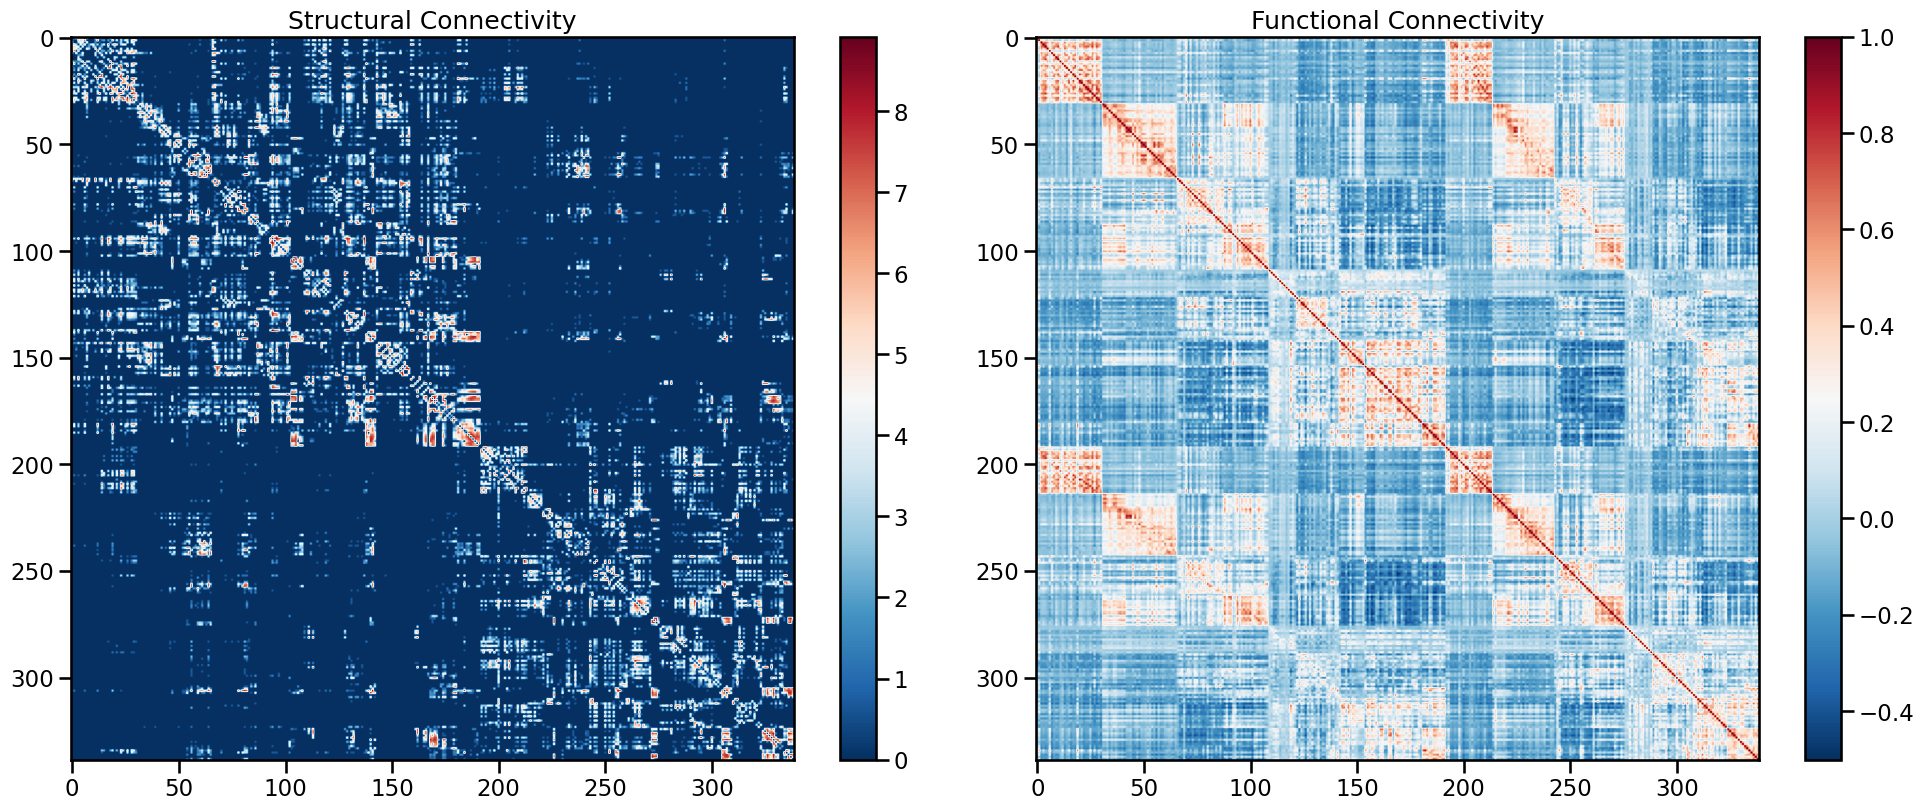

In [68]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='RdBu_r')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r')
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


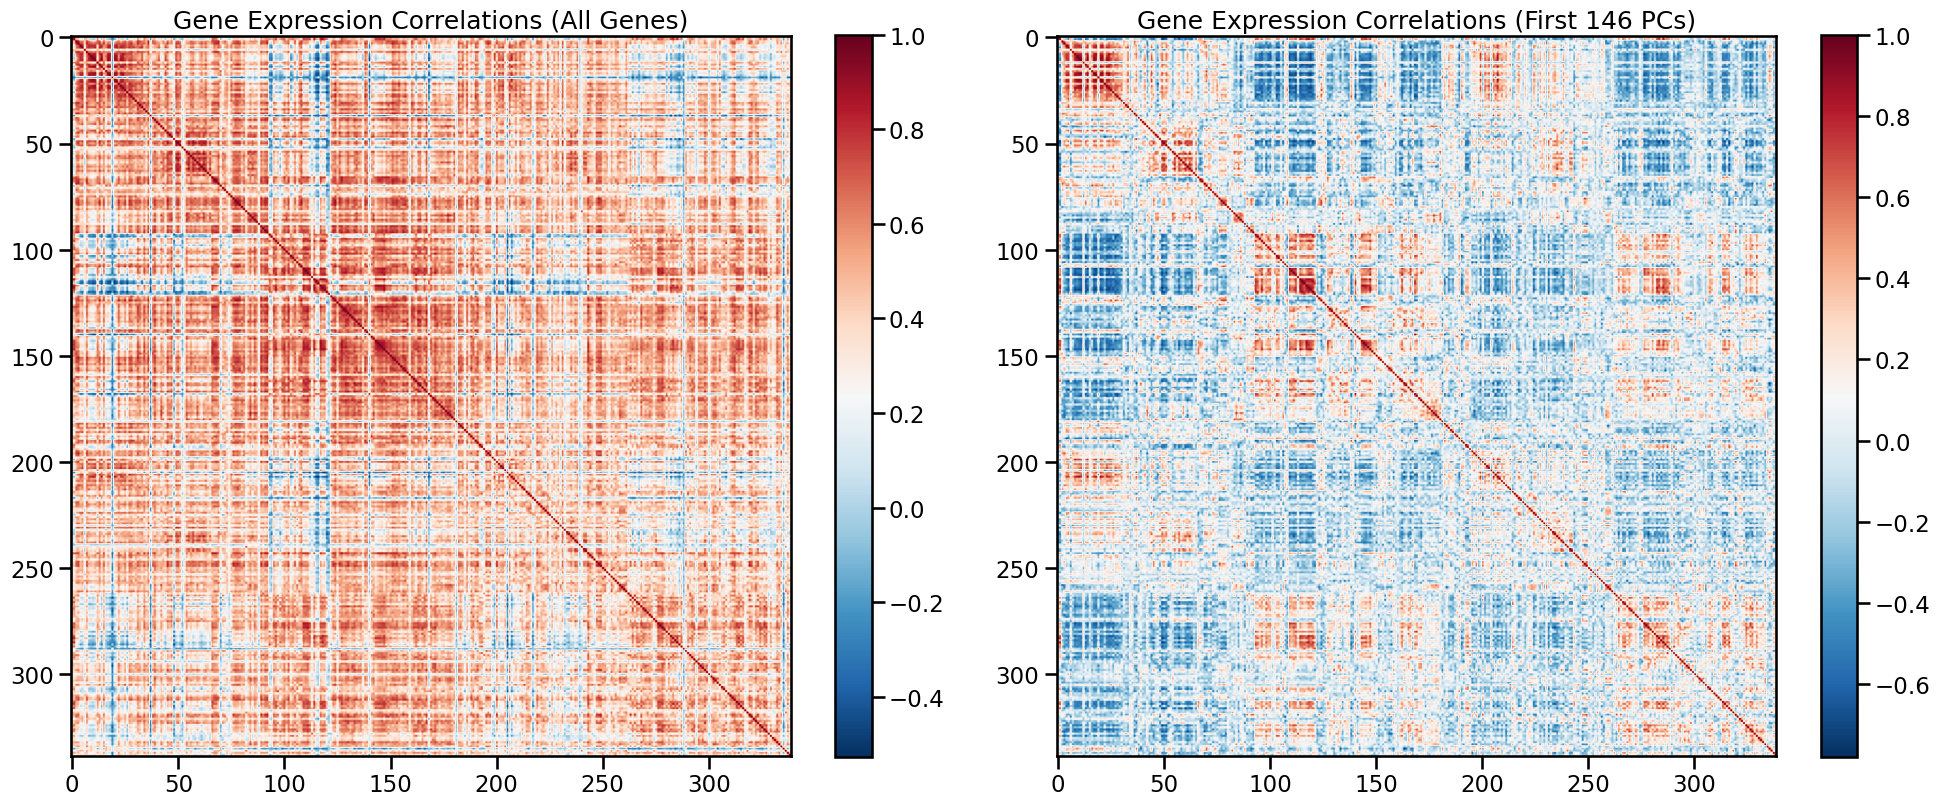

In [69]:
# Calculate gene expression correlations between regions
gene_corr = np.corrcoef(X)

# Calculate PCA of gene expression
pca = PCA()
X_pca = pca.fit_transform(X)

# Find number of components for 95% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
X_pca_95 = X_pca[:, :n_components]

# Calculate correlations using PCA-reduced gene expression
gene_corr_pca = np.corrcoef(X_pca_95)

# Visualize gene expression correlations with PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(gene_corr, cmap='RdBu_r')
ax1.set_title('Gene Expression Correlations (All Genes)')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(gene_corr_pca, cmap='RdBu_r')
ax2.set_title(f'Gene Expression Correlations (First {n_components} PCs)')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


Quick test to evaluate necessary number of components for spectral embedding

  return np.asarray(x, float)

  offsets = np.asanyarray(offsets, float)



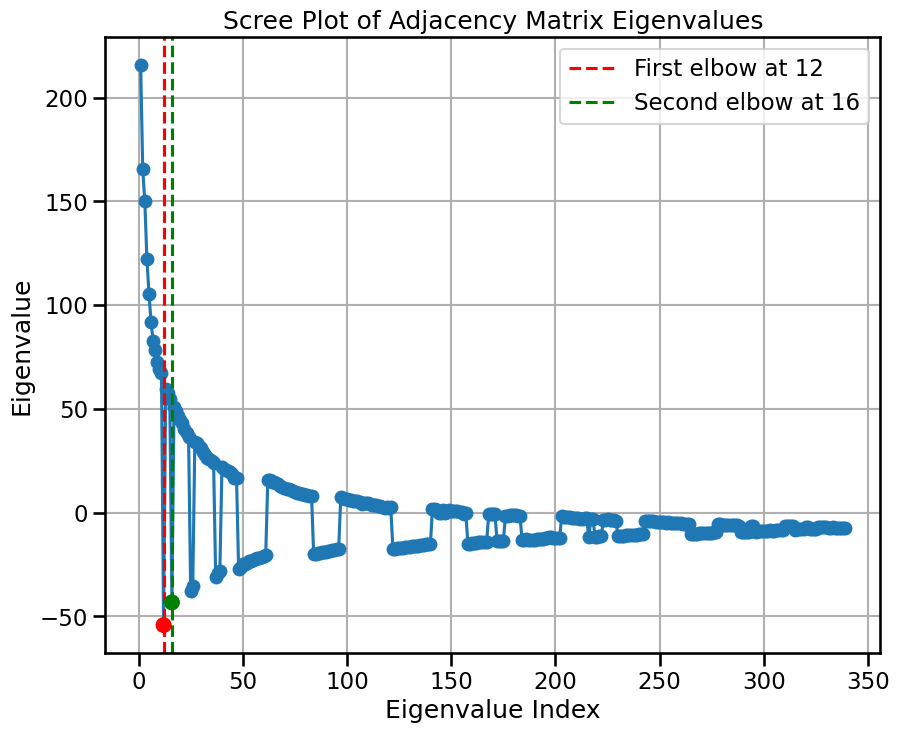

In [70]:
# Compute spectral embeddings using method 'A' on unmasked structural connectivity
adj_eigenvalues, adj_eigenvectors = eig(Y_sc)  # Use unmasked Y_sc

x_adj = range(1, len(adj_eigenvalues) + 1)
d1_adj = np.diff(adj_eigenvalues)
d2_adj = np.diff(d1_adj)
elbow_points_adj = np.argsort(np.abs(d2_adj))[-2:] + 2
first_elbow_adj = min(elbow_points_adj)
second_elbow_adj = max(elbow_points_adj)

# Plot eigenvalues for adjacency matrix embedding
plt.figure(figsize=(10, 8))
plt.plot(x_adj, adj_eigenvalues, marker='o')
plt.axvline(x=first_elbow_adj, color='r', linestyle='--', label=f'First elbow at {first_elbow_adj}')
plt.axvline(x=second_elbow_adj, color='g', linestyle='--', label=f'Second elbow at {second_elbow_adj}')
plt.scatter([first_elbow_adj, second_elbow_adj], 
           [adj_eigenvalues[first_elbow_adj-1], adj_eigenvalues[second_elbow_adj-1]], 
           color=['red', 'green'], s=100, zorder=5)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot of Adjacency Matrix Eigenvalues')
plt.legend()
plt.grid(True)
plt.show()

Dataset creation function

In [75]:
def construct_features_masked(X, Y_sc, Y_fc, mni_coords, mask_from, mask_to, spectrals):
    """
    Construct features for GLM modeling from input data matrices using masks to specify regions.
    
    Args:
        X: Full gene expression data matrix (AHBA_cortical_transcriptome)
        Y_sc: Full structural connectivity matrix
        Y_fc: Full functional connectivity matrix  
        mni_coords: MNI coordinates for all regions
        mask_from: Boolean mask for source regions (e.g. cortical_mask, left_hemi_mask)
        mask_to: Boolean mask for target regions (e.g. cortical_mask, right_hemi_mask)
        
    Returns:
        Dictionary containing feature arrays and embeddings for the masked subset
    """
    # Get masked coordinates and connectivity matrices
    mni_coords_from = mni_coords[mask_from]
    mni_coords_to = mni_coords[mask_to]
    
    # Get masked connectivity matrices
    Y_sc_masked = Y_sc[mask_from][:, mask_to]
    Y_fc_masked = Y_fc[mask_from][:, mask_to]

    # Compute spectral embeddings using method 'A' on unmasked structural connectivity
    _, eigenvectors = eig(Y_sc)  # Use unmasked Y_sc
    spectral_embeddings_from = eigenvectors[mask_from, :spectrals]  # Apply mask_from after computing eigenvectors
    spectral_embeddings_to = eigenvectors[mask_to, :spectrals]  # Apply mask_to after computing eigenvectors

    # Compute PCA from all gene expression data - determine components for 95% variance
    pca = PCA()
    X_pca_full = pca.fit_transform(X)  # Use unmasked X
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    # Get masked PCA components
    X_pca_masked_from = X_pca_full[mask_from]
    X_pca_masked_to = X_pca_full[mask_to]
    
    # Get masked gene expression
    X_masked_from = X[mask_from]
    X_masked_to = X[mask_to]

    # Calculate features between all pairs of masked regions
    num_from = len(mni_coords_from)
    num_to = len(mni_coords_to)
    
    distances = []
    sc_values = []
    fc_values = [] 
    gene_coexpression = []
    gene_PCA_coexpression = []
    spectral_similarity = []
    edge_PCA_embeddings = []
    edge_spectral_embeddings = []
    edge_mni_coords = []

    for i in range(num_from):
        for j in range(num_to):
            # Skip self-connections if masks overlap
            if mask_from is mask_to and i >= j:
                continue
                
            # Calculate euclidean distance between regions i and j
            dist = np.sqrt(np.sum((mni_coords_from[i] - mni_coords_to[j])**2))
            distances.append(dist)
            
            # Get connectivity values between regions i and j
            sc_values.append(Y_sc_masked[i, j])
            fc_values.append(Y_fc_masked[i, j])
            
            # Calculate gene expression similarity
            gene_coexp = np.corrcoef(X_masked_from[i], X_masked_to[j])[0,1]
            gene_coexpression.append(gene_coexp)
            
            # Calculate PCA-based gene expression similarity
            gene_pca_coexp = np.corrcoef(X_pca_masked_from[i], X_pca_masked_to[j])[0,1]
            gene_PCA_coexpression.append(gene_pca_coexp)
            
            # Calculate spectral embedding similarity
            spec_sim = np.corrcoef(spectral_embeddings_from[i], spectral_embeddings_to[j])[0,1]
            spectral_similarity.append(spec_sim)
            
            # Store embeddings
            edge_PCA_embeddings.append(np.concatenate([X_pca_masked_from[i], X_pca_masked_to[j]]))
            edge_spectral_embeddings.append(np.concatenate([spectral_embeddings_from[i], spectral_embeddings_to[j]]))
            edge_mni_coords.append(np.concatenate([mni_coords_from[i], mni_coords_to[j]]))

    # Convert lists to arrays
    features = {
        'distances': np.array(distances),
        'sc_values': np.array(sc_values),
        'fc_values': np.array(fc_values),
        'gene_coexpression': np.array(gene_coexpression),
        'gene_PCA_coexpression': np.array(gene_PCA_coexpression),
        'spectral_similarity': np.array(spectral_similarity),
        'edge_PCA_embeddings': np.array(edge_PCA_embeddings),
        'edge_spectral_embeddings': np.array(edge_spectral_embeddings),
        'edge_mni_coords': np.array(edge_mni_coords)
    }
    
    return features

In [77]:
# Call the function with our datasets
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=cortical_mask,
    mask_to=cortical_mask, 
    spectrals=13
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)

def fit_glm(features, feature_names, target_name='fc_values'):
    """
    Fit GLM model with specified features and calculate individual R^2 values
    
    Parameters:
    features (dict): Dictionary containing feature arrays
    feature_names (list): List of feature names to include in model
    target_name (str): Name of target feature to predict (default: 'fc_values')
    """
    # Get target variable
    target = features[target_name]
    
    # Prepare data for GLM
    X_glm = np.column_stack([features[name] for name in feature_names])
    X_glm = sm.add_constant(X_glm)  # Add constant
    
    print("Feature matrix shape:", X_glm.shape)
    
    # Fit full model
    model = sm.OLS(target, X_glm)
    results = model.fit()
    
    # Print full model summary
    print("\nFull model summary:")
    print(results.summary())
    
    # Calculate R^2 for individual features
    print("\nIndividual feature R^2 values:")
    r_squared_values = {}
    for name in feature_names:
        X_single = sm.add_constant(features[name])
        r_squared = sm.OLS(target, X_single).fit().rsquared
        r_squared_values[name] = r_squared
        print(f"R^2 for {name}: {r_squared:.3f}")
        
    return results, r_squared_values

# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Distances shape: (57291,)
SC values shape: (57291,)
FC values shape: (57291,)
Gene coexpression shape: (57291,)
Gene PCA coexpression shape: (57291,)
Spectral similarity shape: (57291,)
Gene PCA shape: (57291, 678)
Spectral embeddings shape: (57291, 26)
MNI coordinates shape: (57291, 6)
Feature matrix shape: (57291, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1660.
Date:                Wed, 29 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:26:11   Log-Likelihood:                 15046.
No. Observations:               57291   AIC:                        -3.008e+04
Df Residuals:                   57285   BIC:                        -3.003e+04
Df Model:                 

In [78]:
def analyze_feature_correlations(features, feature_names=None, labels=None):
    """
    Analyze correlations between features and check for NaN values.
    
    Parameters:
    features (dict): Dictionary containing feature arrays
    feature_names (list): List of feature names to analyze. If None, uses default list.
    labels (list): List of labels for plotting. If None, uses default list.
    """
    if feature_names is None:
        feature_names = ['distances', 'sc_values', 'fc_values', 'gene_coexpression', 
                        'gene_PCA_coexpression', 'spectral_similarity']
    if labels is None:
        labels = ['Distance', 'SC', 'FC', 'Gene Coexp', 'Gene PCA', 'Spectral']
        
    # Check for NaNs in each feature
    for name in feature_names:
        nan_mask = np.isnan(features[name])
        if np.any(nan_mask):
            print(f"NaNs detected in {name} at indices: {np.where(nan_mask)}")

    # Compute correlations between all pairs of features
    n = len(feature_names)
    correlations = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            correlations[i,j] = np.corrcoef(features[feature_names[i]], 
                                          features[feature_names[j]])[0,1]

    # Create heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(correlations,
                xticklabels=labels,
                yticklabels=labels, 
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                vmin=-1,
                vmax=1,
                square=True)
    plt.title('Correlation heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print individual correlations for reference
    print("\nDetailed correlations:")
    for i in range(n):
        for j in range(i+1,n):
            print(f"Correlation between {labels[i]} and {labels[j]}: {correlations[i,j]:.3f}")
            
    return correlations

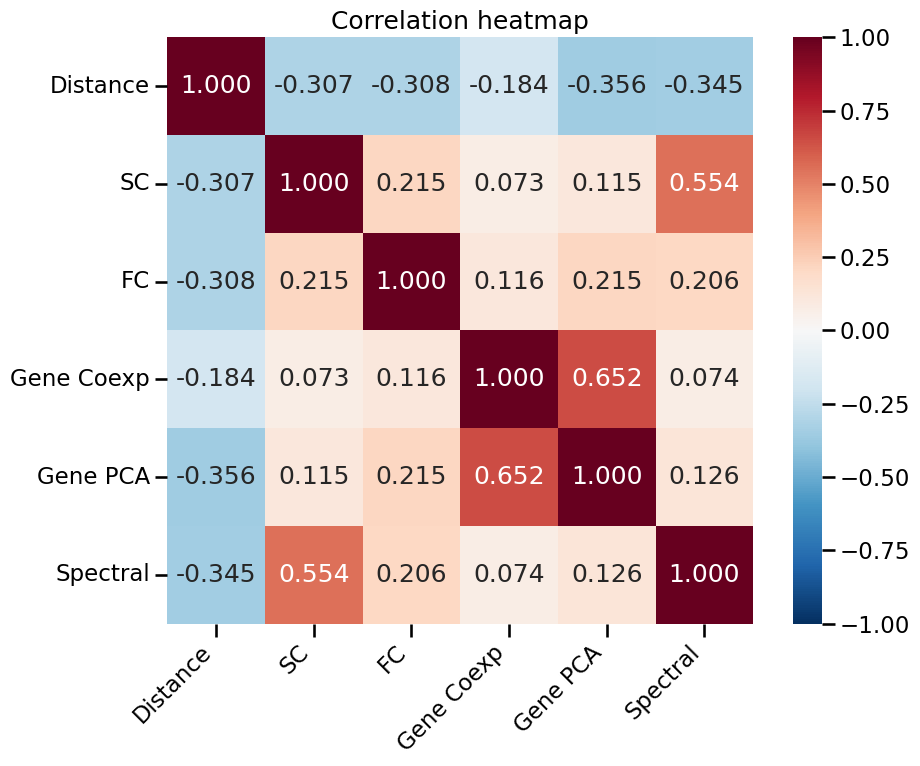


Detailed correlations:
Correlation between Distance and SC: -0.307
Correlation between Distance and FC: -0.308
Correlation between Distance and Gene Coexp: -0.184
Correlation between Distance and Gene PCA: -0.356
Correlation between Distance and Spectral: -0.345
Correlation between SC and FC: 0.215
Correlation between SC and Gene Coexp: 0.073
Correlation between SC and Gene PCA: 0.115
Correlation between SC and Spectral: 0.554
Correlation between FC and Gene Coexp: 0.116
Correlation between FC and Gene PCA: 0.215
Correlation between FC and Spectral: 0.206
Correlation between Gene Coexp and Gene PCA: 0.652
Correlation between Gene Coexp and Spectral: 0.074
Correlation between Gene PCA and Spectral: 0.126


array([[ 1.        , -0.30735148, -0.30845297, -0.18350044, -0.35551399,
        -0.34484971],
       [-0.30735148,  1.        ,  0.21521423,  0.07313917,  0.11466346,
         0.55430844],
       [-0.30845297,  0.21521423,  1.        ,  0.11596462,  0.21545001,
         0.20609242],
       [-0.18350044,  0.07313917,  0.11596462,  1.        ,  0.65235295,
         0.07376624],
       [-0.35551399,  0.11466346,  0.21545001,  0.65235295,  1.        ,
         0.12571745],
       [-0.34484971,  0.55430844,  0.20609242,  0.07376624,  0.12571745,
         1.        ]])

In [81]:
# Call the function with default parameters
analyze_feature_correlations(features)

Left hemisphere only 

In [82]:
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=left_hemi_mask,
    mask_to=left_hemi_mask, 
    spectrals=13
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)

Distances shape: (18336,)
SC values shape: (18336,)
FC values shape: (18336,)
Gene coexpression shape: (18336,)
Gene PCA coexpression shape: (18336,)
Spectral similarity shape: (18336,)
Gene PCA shape: (18336, 678)
Spectral embeddings shape: (18336, 26)
MNI coordinates shape: (18336, 6)


In [83]:
# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Feature matrix shape: (18336, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     705.2
Date:                Wed, 29 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:27:30   Log-Likelihood:                 4383.6
No. Observations:               18336   AIC:                            -8755.
Df Residuals:                   18330   BIC:                            -8708.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

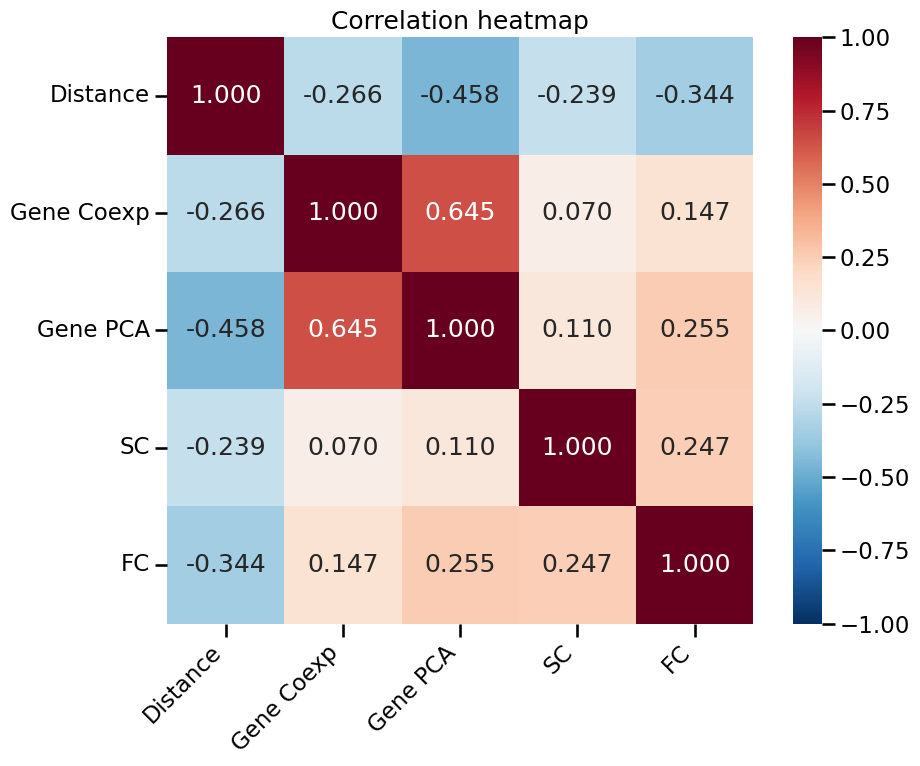


Detailed correlations:
Correlation between Distance and Gene Coexp: -0.266
Correlation between Distance and Gene PCA: -0.458
Correlation between Distance and SC: -0.239
Correlation between Distance and FC: -0.344
Correlation between Gene Coexp and Gene PCA: 0.645
Correlation between Gene Coexp and SC: 0.070
Correlation between Gene Coexp and FC: 0.147
Correlation between Gene PCA and SC: 0.110
Correlation between Gene PCA and FC: 0.255
Correlation between SC and FC: 0.247


array([[ 1.        , -0.26587731, -0.45830051, -0.23853711, -0.3442392 ],
       [-0.26587731,  1.        ,  0.64458323,  0.07030201,  0.14731359],
       [-0.45830051,  0.64458323,  1.        ,  0.11040392,  0.25537497],
       [-0.23853711,  0.07030201,  0.11040392,  1.        ,  0.24673915],
       [-0.3442392 ,  0.14731359,  0.25537497,  0.24673915,  1.        ]])

In [84]:
feature_names = ['distances', 'gene_coexpression', 'gene_PCA_coexpression', 'sc_values', 'fc_values',]
labels = ['Distance', 'Gene Coexp', 'Gene PCA', 'SC', 'FC',]

analyze_feature_correlations(features, feature_names, labels)

Right hemisphere only

In [152]:
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=right_hemi_mask,
    mask_to=right_hemi_mask
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)


Distances shape: (10731,)
SC values shape: (10731,)
FC values shape: (10731,)
Gene coexpression shape: (10731,)
Gene PCA coexpression shape: (10731,)
Spectral similarity shape: (10731,)
Gene PCA shape: (10731, 678)
Spectral embeddings shape: (10731, 28)
MNI coordinates shape: (10731, 6)


In [153]:
# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Feature matrix shape: (10731, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     456.3
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:28:42   Log-Likelihood:                 3072.4
No. Observations:               10731   AIC:                            -6133.
Df Residuals:                   10725   BIC:                            -6089.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Interhemispheric connections only

In [154]:
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=left_hemi_mask,
    mask_to=right_hemi_mask
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)


Distances shape: (28224,)
SC values shape: (28224,)
FC values shape: (28224,)
Gene coexpression shape: (28224,)
Gene PCA coexpression shape: (28224,)
Spectral similarity shape: (28224,)
Gene PCA shape: (28224, 678)
Spectral embeddings shape: (28224, 28)
MNI coordinates shape: (28224, 6)


In [155]:
# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Feature matrix shape: (28224, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     561.3
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:28:50   Log-Likelihood:                 7890.9
No. Observations:               28224   AIC:                        -1.577e+04
Df Residuals:                   28218   BIC:                        -1.572e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

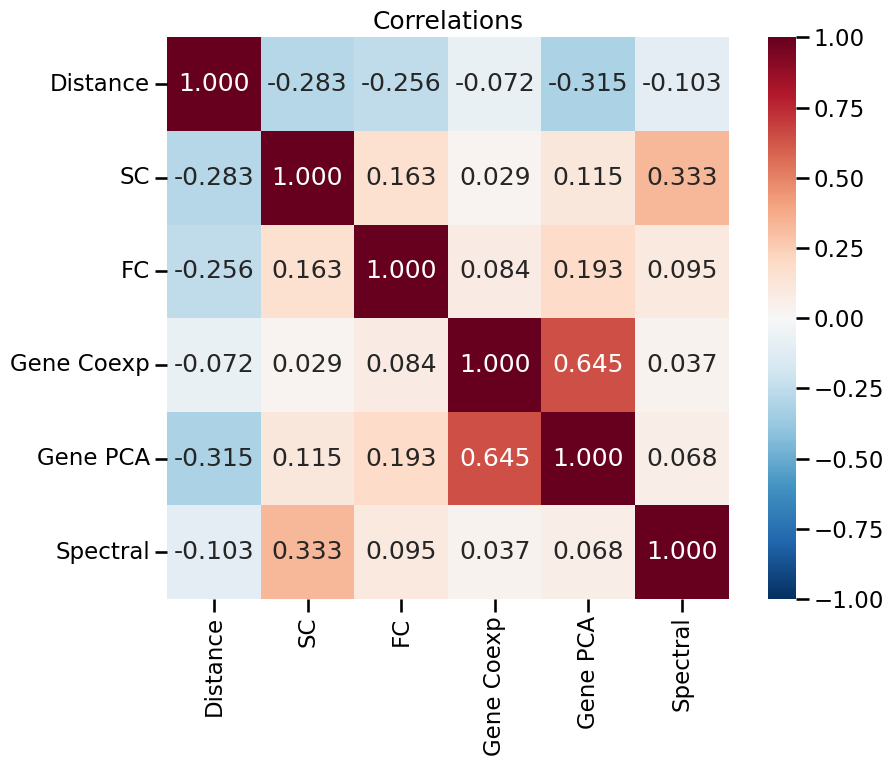


Detailed correlations:
Correlation between Distance and SC: -0.283
Correlation between Distance and FC: -0.256
Correlation between Distance and Gene Coexp: -0.072
Correlation between Distance and Gene PCA: -0.315
Correlation between Distance and Spectral: -0.103
Correlation between SC and FC: 0.163
Correlation between SC and Gene Coexp: 0.029
Correlation between SC and Gene PCA: 0.115
Correlation between SC and Spectral: 0.333
Correlation between FC and Gene Coexp: 0.084
Correlation between FC and Gene PCA: 0.193
Correlation between FC and Spectral: 0.095
Correlation between Gene Coexp and Gene PCA: 0.645
Correlation between Gene Coexp and Spectral: 0.037
Correlation between Gene PCA and Spectral: 0.068


array([[ 1.        , -0.28266103, -0.25598233, -0.0718463 , -0.31463783,
        -0.10282188],
       [-0.28266103,  1.        ,  0.16271542,  0.02933041,  0.11474613,
         0.332918  ],
       [-0.25598233,  0.16271542,  1.        ,  0.08390841,  0.19253781,
         0.09487894],
       [-0.0718463 ,  0.02933041,  0.08390841,  1.        ,  0.644547  ,
         0.03694787],
       [-0.31463783,  0.11474613,  0.19253781,  0.644547  ,  1.        ,
         0.06829012],
       [-0.10282188,  0.332918  ,  0.09487894,  0.03694787,  0.06829012,
         1.        ]])

In [108]:
# Call the function with default parameters
analyze_feature_correlations(features)